<a href="https://colab.research.google.com/github/PremCodes2005/Mall-Customer-Segmentation-using-K-Means-Clustering/blob/main/MALL_CUSTOMER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING THE LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", None)


PATH = "Mall_Customers.csv"
df = pd.read_csv(PATH)

print("Shape:", df.shape)
df.head()


Shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**EXPLORATORY DATA ANALYSIS AND FEATURE SELECTION**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
                        count unique     top freq   mean        std   min  \
CustomerID              200.0    NaN     NaN  NaN  100.5  57.879185   1.0   
Genre                     200      2  Female  112    NaN        NaN   NaN   
Age                     200.0    NaN     NaN  NaN  38.85  13.969007  18.0   
Annual Income (k$)      200.0    NaN     NaN  NaN  60.56  26.264721  15.0   
Spending Score (1-100)  200.0    NaN     NaN  NaN   50.2  25.823522   1.0   

              

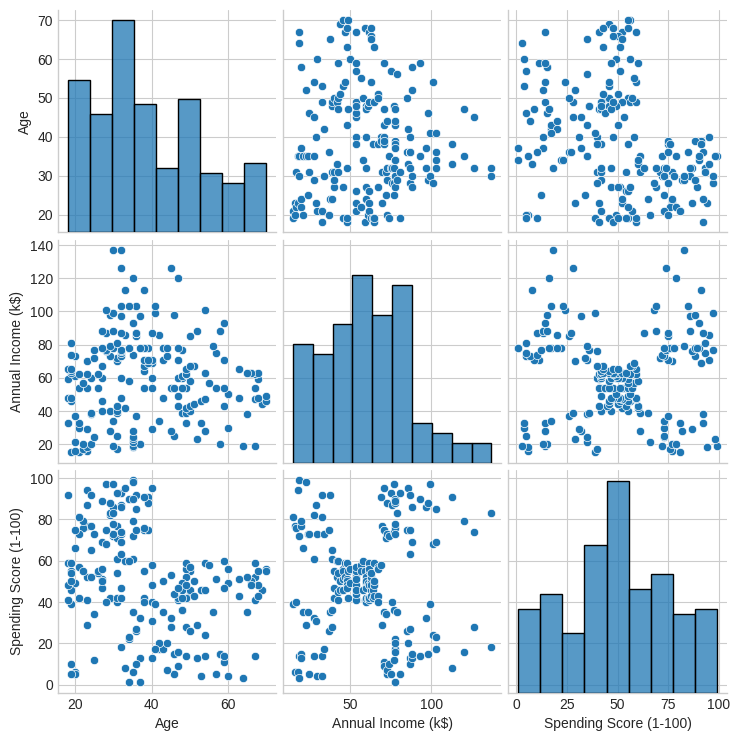

In [2]:
print(df.info())
print(df.describe(include="all").T)

num_cols = ["Age","Annual Income (k$)","Spending Score (1-100)"]
sns.pairplot(df[num_cols])
plt.show()

X = df[num_cols].copy()


**STANDARDIZING PROCESS**

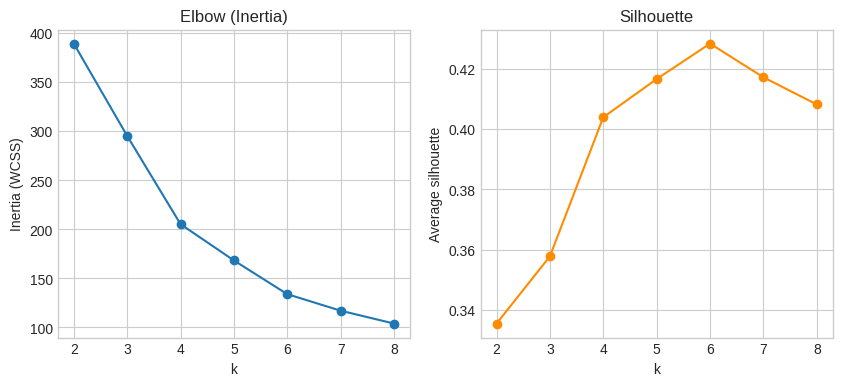

Chosen k: 6


In [3]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

inertias, sils, Ks = [], [], range(2, 9)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xs, labels))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(Ks), inertias, marker="o")
ax[0].set_title("Elbow (Inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia (WCSS)")

ax[1].plot(list(Ks), sils, marker="o", color="darkorange")
ax[1].set_title("Silhouette")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Average silhouette")
plt.show()

# Simple selection: pick k with max silhouette
best_k = Ks[int(np.argmax(sils))]
print("Chosen k:", best_k)


**FITTING K-MEANS AND ANALYZING CLUSTERS**

In [4]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(Xs)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# Cluster sizes
print("Cluster sizes:")
print(df_clusters["cluster"].value_counts().sort_index())

# Cluster profiles in original scale
profiles = df_clusters.groupby("cluster")[num_cols].mean().round(2)
profiles["count"] = df_clusters.groupby("cluster").size()
profiles


Cluster sizes:
cluster
0    45
1    39
2    33
3    39
4    23
5    21
Name: count, dtype: int64


,Age,Annual Income (k$),Spending Score (1-100),count
cluster,,,,
0,56.33,54.27,49.07,45
1,26.79,57.10,48.13,39
2,41.94,88.94,16.97,33
3,32.69,86.54,82.13,39
4,25.00,25.26,77.61,23
5,45.52,26.29,19.38,21


**VISUALIZATION**

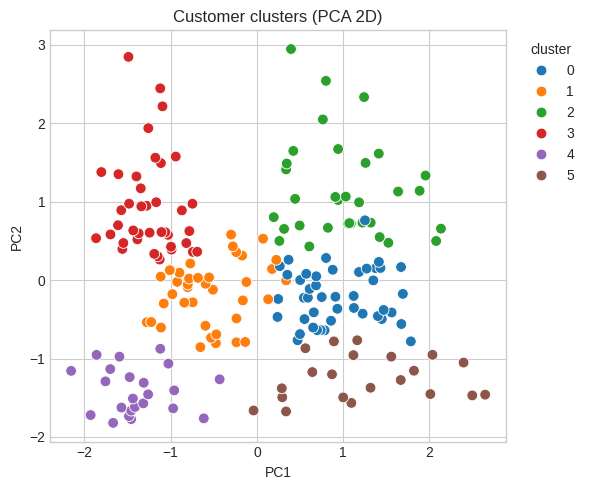

In [5]:
pca = PCA(n_components=2, random_state=42)
Xs_2d = pca.fit_transform(Xs)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=Xs_2d[:, 0], y=Xs_2d[:, 1], hue=labels, palette="tab10", s=60)
plt.title("Customer clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


**SEGMENTATION TAGS**

In [8]:
# Build quick tags based on median splits; adjust thresholds after inspecting `profiles`
inc_med = profiles["Annual Income (k$)"].median()
spend_med = profiles["Spending Score (1-100)"].median()

tags = {}
for c in profiles.index:
    inc = profiles.loc[c, "Annual Income (k$)"]
    spend = profiles.loc[c, "Spending Score (1-100)"]
    if inc >= inc_med and spend >= spend_med:
        tags[c] = "Premium/high-spend"
    elif inc >= inc_med and spend < spend_med:
        tags[c] = "Affluent/low-spend"
    elif inc < inc_med and spend >= spend_med:
        tags[c] = "Value-seeking/high-spend"
    else:
        tags[c] = "Budget/low-spend"

df_clusters["segment"] = df_clusters["cluster"].map(tags)
df_clusters.head(100)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),cluster,segment
0,1,Male,19,15,39,4,Value-seeking/high-spend
1,2,Male,21,15,81,4,Value-seeking/high-spend
2,3,Female,20,16,6,5,Budget/low-spend
3,4,Female,23,16,77,4,Value-seeking/high-spend
4,5,Female,31,17,40,5,Budget/low-spend
...,...,...,...,...,...,...,...
95,96,Male,24,60,52,1,Affluent/low-spend
96,97,Female,47,60,47,0,Value-seeking/high-spend
97,98,Female,27,60,50,1,Affluent/low-spend
98,99,Male,48,61,42,0,Value-seeking/high-spend


**SAVING THE OUTPUT**

In [9]:
df_clusters.to_csv("mall_customer_clusters.csv", index=False)
profiles.to_csv("mall_cluster_profiles.csv")
print("Saved mall_customer_clusters.csv and mall_cluster_profiles.csv")


Saved mall_customer_clusters.csv and mall_cluster_profiles.csv
